In [17]:
import pandas as pd
import glob

common_prefix = 'cleaned_'
path = f'{common_prefix}*.csv'


all_files = glob.glob(path)


dataframes = []

for filename in all_files:
    df = pd.read_csv(filename)
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.to_csv('combined.csv', index=False)

CSV files with the specified prefix have been combined successfully!


C:\Users\ARC\AppData\Local\Temp\ipykernel_12880\3466611643.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['model_threshold'].fillna(method='ffill', inplace=True)
C:\Users\ARC\AppData\Local\Temp\ipykernel_12880\3466611643.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['model_threshold'].fillna(method='ffill', inplace=True)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best F1 Score: 0.81
Accuracy: 0.9690641918020109
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1174
           1       0.86      0.79      0.82       119

    accuracy                           0.97      1293
   macro avg       0.92      0.89      0.90      1293
weighted avg       0.97      0.97      0.97      1293



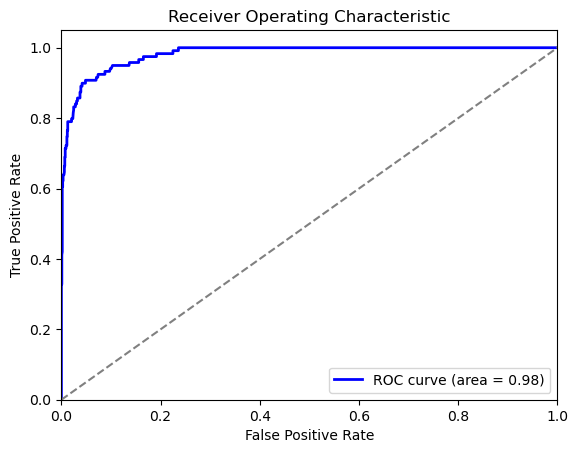

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, f1_score, classification_report, accuracy_score
import xgboost as xgb

cleaned_file_path = 'combined.csv' 
df = pd.read_csv(cleaned_file_path)


df['model_threshold'].fillna(method='ffill', inplace=True)
df.dropna(subset=['sensor_2', 'sensor_4'], inplace=True)
df = df.drop(columns=['mv_1', 'mv_2', 'mv_3', 'mv_4', 'fhp', 'notes', 'model_notes'])
df['abs_diff'] = (df['sensor_2'] - df['sensor_4']).abs()
df['prediction'] = np.where(df['abs_diff'] > df['model_threshold'], 0, 1)

# IMPORTANT: Define features and target variable
X = df[['sensor_2', 'sensor_4', 'abs_diff']]  # Features
y = np.where(df['bad_posture_command'] == 'yes', 1, 0)  # Target variable (1 for bad posture)


if np.any(np.isnan(X)) or np.any(np.isinf(X)):
    print("Feature matrix contains NaN or infinite values. Please check your data.")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
xgb_model = xgb.XGBClassifier(eval_metric='logloss')

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='f1', cv=5, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best F1 Score: {grid_search.best_score_:.2f}')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_scores = best_model.predict_proba(X_test)[:, 1]  
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

C:\Users\ARC\AppData\Local\Temp\ipykernel_12880\2428383762.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['model_threshold'].fillna(method='ffill', inplace=True)
C:\Users\ARC\AppData\Local\Temp\ipykernel_12880\2428383762.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['model_threshold'].fillna(method='ffill', inplace=True)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\ARC\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning: [22:50:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
Best F1 Score: 0.96
Accuracy: 0.9599483204134367
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1171
           1       0.94      0.99      0.96      1151

    accuracy                           0.96      2322
   macro avg       0.96      0.96      0.96      2322
weighted avg       0.96      0.96      0.96      2322



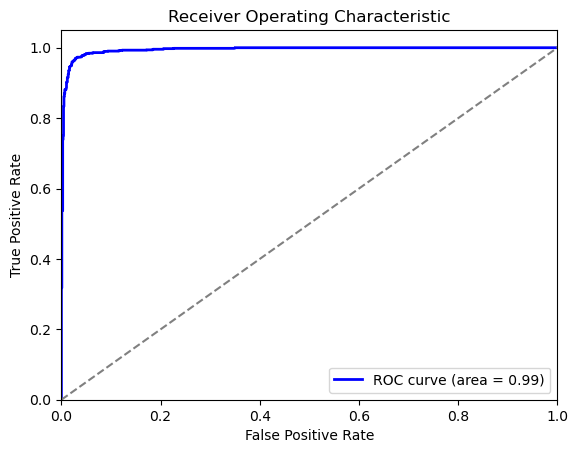

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from imblearn.over_sampling import SMOTE  # For oversampling
import xgboost as xgb

cleaned_file_path = 'combined.csv'  # Replace with the actual path
df = pd.read_csv(cleaned_file_path)
df['model_threshold'].fillna(method='ffill', inplace=True)
df.dropna(subset=['sensor_2', 'sensor_4'], inplace=True)
df = df.drop(columns=['mv_1', 'mv_2', 'mv_3', 'mv_4', 'fhp', 'notes', 'model_notes'])
df['abs_diff'] = (df['sensor_2'] - df['sensor_4']).abs()

X = df[['sensor_2', 'sensor_4', 'abs_diff']]
y = np.where(df['bad_posture_command'] == 'yes', 1, 0)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
xgb_model = xgb.XGBClassifier(scale_pos_weight=len(y) / np.sum(y), use_label_encoder=False, eval_metric='logloss')
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='f1', cv=5, verbose=2, n_jobs=-1)

grid_search.fit(X_train, y_train)
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best F1 Score: {grid_search.best_score_:.2f}')

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_scores = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()